In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


In [2]:
data = pd.read_csv("melb_data.csv")

In [3]:
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [4]:
data.shape

(13580, 21)

In [5]:
data.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [6]:
features = [
    "Rooms", "Bathroom", "Bedroom2",
    "Car", "Landsize", "Distance",
    "Regionname", "CouncilArea"
]

target = "Price"

df = data[features + [target]].copy()

In [7]:
df = df.dropna(subset=["Rooms", "Bathroom", "Bedroom2", "Landsize", "Distance", "Price"])


In [8]:
df = df[df["Landsize"] > 0]  # Prevent log errors

df["Log_Price"] = np.log(df["Price"])
df["Log_Landsize"] = np.log(df["Landsize"])


In [9]:
df = pd.get_dummies(df, columns=["Regionname", "CouncilArea"], drop_first=False)


In [10]:
df.columns


Index(['Rooms', 'Bathroom', 'Bedroom2', 'Car', 'Landsize', 'Distance', 'Price',
       'Log_Price', 'Log_Landsize', 'Regionname_Eastern Metropolitan',
       'Regionname_Eastern Victoria', 'Regionname_Northern Metropolitan',
       'Regionname_Northern Victoria', 'Regionname_South-Eastern Metropolitan',
       'Regionname_Southern Metropolitan', 'Regionname_Western Metropolitan',
       'Regionname_Western Victoria', 'CouncilArea_Banyule',
       'CouncilArea_Bayside', 'CouncilArea_Boroondara', 'CouncilArea_Brimbank',
       'CouncilArea_Cardinia', 'CouncilArea_Casey', 'CouncilArea_Darebin',
       'CouncilArea_Frankston', 'CouncilArea_Glen Eira',
       'CouncilArea_Greater Dandenong', 'CouncilArea_Hobsons Bay',
       'CouncilArea_Hume', 'CouncilArea_Kingston', 'CouncilArea_Knox',
       'CouncilArea_Macedon Ranges', 'CouncilArea_Manningham',
       'CouncilArea_Maribyrnong', 'CouncilArea_Maroondah',
       'CouncilArea_Melbourne', 'CouncilArea_Melton', 'CouncilArea_Monash',
       '

In [11]:
df["Car"] = df["Car"].fillna(0)


In [12]:
num_features = ["Rooms", "Bathroom", "Bedroom2", "Car", "Log_Landsize", "Distance"]


In [13]:
cat_features = [col for col in df.columns if col.startswith("Regionname_") or col.startswith("CouncilArea_")]


In [14]:
X = df[num_features + cat_features]
y = df["Log_Price"]


In [15]:
X.isna().sum().sort_values(ascending=False)


Rooms                                    0
CouncilArea_Moonee Valley                0
CouncilArea_Kingston                     0
CouncilArea_Knox                         0
CouncilArea_Macedon Ranges               0
CouncilArea_Manningham                   0
CouncilArea_Maribyrnong                  0
CouncilArea_Maroondah                    0
CouncilArea_Melbourne                    0
CouncilArea_Melton                       0
CouncilArea_Monash                       0
CouncilArea_Moorabool                    0
CouncilArea_Hobsons Bay                  0
CouncilArea_Moreland                     0
CouncilArea_Nillumbik                    0
CouncilArea_Port Phillip                 0
CouncilArea_Stonnington                  0
CouncilArea_Unavailable                  0
CouncilArea_Whitehorse                   0
CouncilArea_Whittlesea                   0
CouncilArea_Wyndham                      0
CouncilArea_Yarra                        0
CouncilArea_Hume                         0
CouncilArea

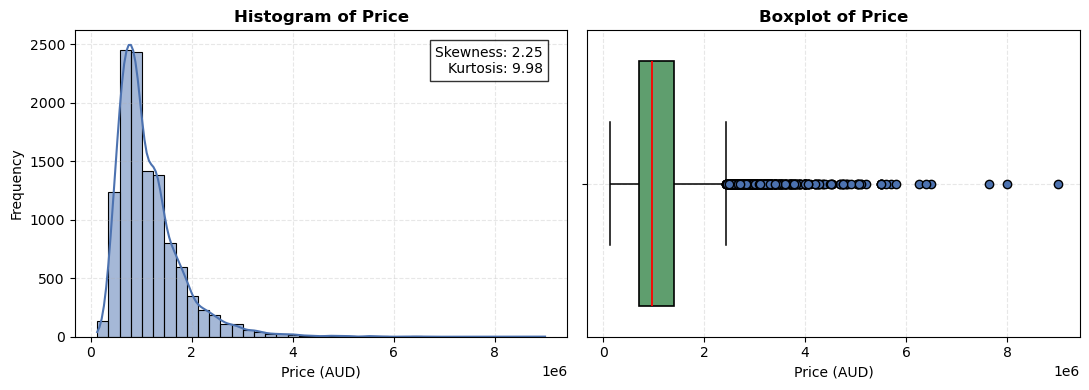

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Custom colors (same as Log_Price figure)
hist_color = "#4C72B0"     # Blue
box_color  = "#55A868"     # Green
edge_color = "black"       # Black outline

# --- Extract Price ---
price = df["Price"]

# --- Compute Skewness & Kurtosis ---
skew_val = price.skew()
kurt_val = price.kurt()

# --- Plot ---
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

# ========== HISTOGRAM ==========
sns.histplot(
    price, bins=40, kde=True,
    color=hist_color, edgecolor=edge_color, linewidth=0.8, ax=ax[0]
)

ax[0].set_title("Histogram of Price", fontsize=12, weight='bold')
ax[0].set_xlabel("Price (AUD)")
ax[0].set_ylabel("Frequency")
ax[0].grid(True, linestyle='--', alpha=0.3)

# Annotation box
textstr = f"Skewness: {skew_val:.2f}\nKurtosis: {kurt_val:.2f}"
ax[0].text(
    0.95, 0.95, textstr,
    transform=ax[0].transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8)
)

# ========== BOXPLOT ==========
sns.boxplot(
    x=price, 
    color=box_color, 
    ax=ax[1],
    boxprops=dict(edgecolor=edge_color, linewidth=1.2),
    medianprops=dict(color="red", linewidth=1.3),
    whiskerprops=dict(color=edge_color, linewidth=1.1),
    capprops=dict(color=edge_color, linewidth=1.1),
    flierprops=dict(markerfacecolor=hist_color, markeredgecolor=edge_color)
)

ax[1].set_title("Boxplot of Price", fontsize=12, weight='bold')
ax[1].set_xlabel("Price (AUD)")
ax[1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

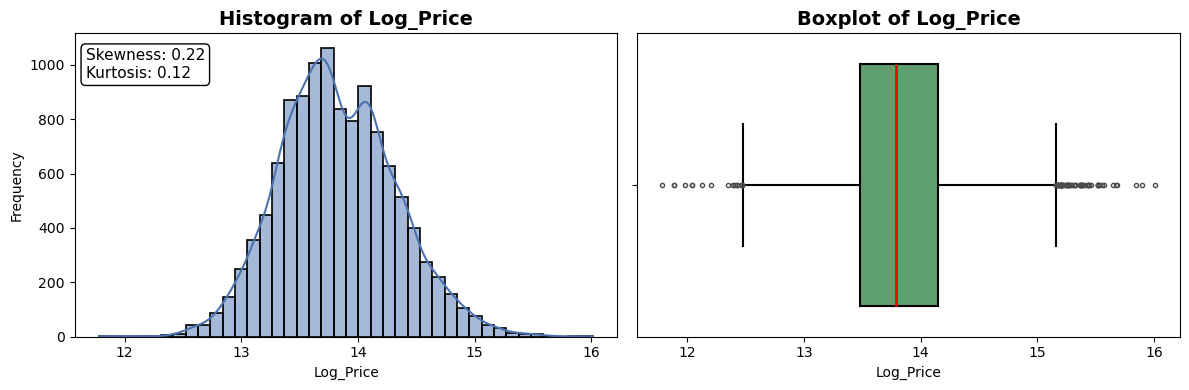

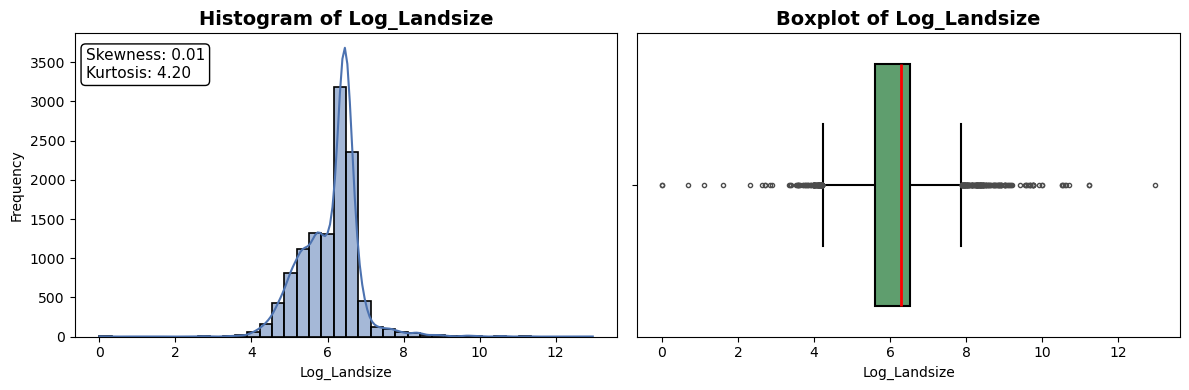

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Custom colors
hist_color = "#4C72B0"      # Blue
box_color = "#55A868"       # Green
edge_color = "black"

features_to_plot = {
    "Log_Price": df["Log_Price"],
    "Log_Landsize": df["Log_Landsize"]
}

for name, series in features_to_plot.items():
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # ---------- Histogram ----------
    sns.histplot(
        series,
        bins=40,
        kde=True,
        color=hist_color,
        edgecolor=edge_color,
        linewidth=1.2,
        ax=ax[0]
    )
    ax[0].set_title(f"Histogram of {name}", fontsize=14, weight='bold')
    ax[0].set_xlabel(name)
    ax[0].set_ylabel("Frequency")

    # Calculate stats
    skew_val = series.skew()
    kurt_val = series.kurtosis()

    # Add skew & kurtosis inside plot (top left corner)
    ax[0].text(
        0.02, 0.95, 
        f"Skewness: {skew_val:.2f}\nKurtosis: {kurt_val:.2f}",
        transform=ax[0].transAxes,
        fontsize=11,
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=edge_color)
    )

    # ---------- Boxplot ----------
    sns.boxplot(
        x=series,
        color=box_color,
        fliersize=3,
        linewidth=1.2,
        boxprops=dict(edgecolor=edge_color, linewidth=1.5),
        medianprops=dict(color="red", linewidth=2),
        whiskerprops=dict(color=edge_color, linewidth=1.5),
        capprops=dict(color=edge_color, linewidth=1.5),
        ax=ax[1]
    )
    ax[1].set_title(f"Boxplot of {name}", fontsize=14, weight='bold')

    plt.tight_layout()
    plt.show()

In [18]:
import numpy as np
from scipy.stats import skew, kurtosis

# Work on a clean copy
df_ppsm = df.copy()

# Remove invalid Landsize values (0, negative, or missing)
df_ppsm = df_ppsm[df_ppsm["Landsize"] > 0]
df_ppsm = df_ppsm.dropna(subset=["Landsize", "Price"])

# Create PPSM
df_ppsm["PPSM"] = df_ppsm["Price"] / df_ppsm["Landsize"]

# Remove infinite PPSM values (just in case)
df_ppsm = df_ppsm.replace([np.inf, -np.inf], np.nan)
df_ppsm = df_ppsm.dropna(subset=["PPSM"])

# Create log-transformed PPSM
df_ppsm["Log_PPSM"] = np.log(df_ppsm["PPSM"])

# Compute statistics
print("Raw PPSM Skew:", skew(df_ppsm["PPSM"]))
print("Raw PPSM Kurt:", kurtosis(df_ppsm["PPSM"]))

print("Log PPSM Skew:", skew(df_ppsm["Log_PPSM"]))
print("Log PPSM Kurt:", kurtosis(df_ppsm["Log_PPSM"]))

Raw PPSM Skew: 48.587421533619754
Raw PPSM Kurt: 2814.183867300368
Log PPSM Skew: -0.544102751027936
Log PPSM Kurt: 3.0185022753422146


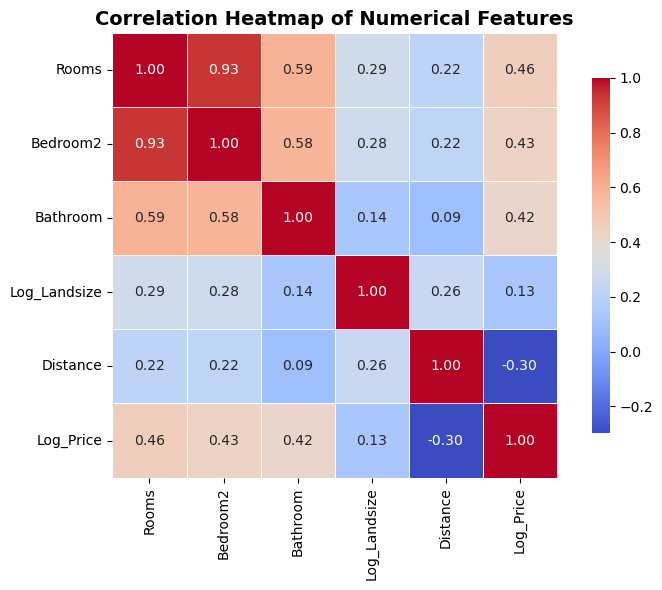

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical variables for correlation
corr_features = ["Rooms", "Bedroom2", "Bathroom", "Log_Landsize", "Distance", "Log_Price"]

corr_matrix = df[corr_features].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Heatmap of Numerical Features", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_features])


In [21]:
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

lasso_coeffs = pd.Series(lasso.coef_, index=num_features)
print(lasso_coeffs)


Rooms           0.173260
Bathroom        0.096457
Bedroom2        0.020623
Car             0.021597
Log_Landsize    0.040892
Distance       -0.209745
dtype: float64


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [23]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(
        random_state=42, learning_rate=0.1, n_estimators=100, max_depth=6
    ),
    "LightGBM": LGBMRegressor(random_state=42)
}


In [24]:
results = {}

for name, model in models.items():

    if name == "Linear Regression":
        model.fit(X_train[num_features], y_train)
        preds = model.predict(X_test[num_features])
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    results[name] = {
        "R2": r2_score(y_test, preds),
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds))
    }

results


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 9312, number of used features: 42
[LightGBM] [Info] Start training from score 13.823299


{'Linear Regression': {'R2': 0.42204415339877543,
  'MAE': 0.3023246990630101,
  'RMSE': 0.380108337539236},
 'Random Forest': {'R2': 0.7782682377585693,
  'MAE': 0.1663146426209293,
  'RMSE': 0.23543662278246966},
 'Gradient Boosting': {'R2': 0.7663013601573728,
  'MAE': 0.17627505987006342,
  'RMSE': 0.24170640416413472},
 'XGBoost': {'R2': 0.8060379416173667,
  'MAE': 0.15753684874918839,
  'RMSE': 0.22020057934368614},
 'LightGBM': {'R2': 0.8109267344610777,
  'MAE': 0.1557910960414495,
  'RMSE': 0.21740780315670746}}

In [25]:
from sklearn.model_selection import RandomizedSearchCV

# Parameter grid
param_grid = {
    "num_leaves": [20, 30, 40, 50, 60],
    "max_depth": [6, 8, 10, -1],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "n_estimators": [300, 500, 700, 900, 1200],
    "subsample": [0.6, 0.7, 0.8],
    "colsample_bytree": [0.6, 0.7, 0.8]
}

lgbm = LGBMRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=30,               # Number of random combinations tested
    scoring="r2",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit tuning
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 9312, number of used features: 42
[LightGBM] [Info] Start training from score 13.823299
Best Parameters: {'subsample': 0.8, 'num_leaves': 30, 'n_estimators': 700, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Best CV Score: 0.8106577148979477


In [26]:
best_lgbm = random_search.best_estimator_

preds = best_lgbm.predict(X_test)

print("Tuned LightGBM Performance:")
print("R²:", r2_score(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))


Tuned LightGBM Performance:
R²: 0.8152879017093632
MAE: 0.15298013385622464
RMSE: 0.21488580912881117
